In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import tensorflow as tf

In [2]:
from sklearn.cross_validation import train_test_split
from scipy.stats import wishart, invwishart, dirichlet

/home/folzd/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
import edward as ed

In [4]:
from edward.models import Categorical, Dirichlet, InverseGamma, Mixture, \
    MultivariateNormalDiag, MultivariateNormalFull, Normal, WishartFull

In [5]:
d = 2
k = 10
n = 20000

In [6]:
alpha0 = 10 # alpha >> 1 yields equal amounts of data from each cluster, alpha << 1 yields one-cluster-dominated-data
m0 = np.ones(d)*0
#nu0 = 10*d # must satisfy nu0 > d-1
nu0 = 10*d
W0 = invwishart.rvs(df = nu0, scale=np.eye(d)) # covariance matrix of the normal distribution
beta0 = 0.01 # the bigger beta is, the more clustered are the clusters

true_parameters = {'alpha0':alpha0,'m0':m0,'nu0':nu0,'W0':W0,'beta0':beta0}

In [7]:
def simulate_data(d,k,n,alpha0,m0,nu0,W0,beta0):
    """
    Samples from a Bayesian Gaussian Mixture
    """
    # outermost/most latent variables
    pi = dirichlet.rvs(alpha=np.ones(k)*alpha0,size=1)
    #inv_lambda = [invwishart.rvs(df = nu0, scale=W0) for i in range(k)]
    lamda = [np.linalg.inv(wishart.rvs(df = nu0, scale=W0)) for i in range(k)]
    
    z = np.random.multinomial(1, *pi, size=n)
    mu = [np.random.multivariate_normal(mean=m0,cov = (1/beta0)*lamda[i], size=1) for i in range(k)]
    
    # Inv-lambda is the covmat both for the mean-prior and the data distribution, but should it be?
    Xks = np.array([np.random.multivariate_normal(mu[i][0],lamda[i],n) for i in range(k)])

    idxs = z.T.astype(np.bool)
    X = Xks[idxs]
    y = np.array([np.ones((n,1))*i for i in range(k)])
    y = y[idxs].astype(np.int)[:,0]
    
    # shuffle points, for the sake of realism, and because kfold down the road doesn't shuffle
    shuffle_idxs = np.random.permutation(n)
    return X[shuffle_idxs,:],y[shuffle_idxs]

In [8]:
X,y = simulate_data(d,k,n,**true_parameters)

In [9]:
X_train, X_test = train_test_split(X,test_size=.9)

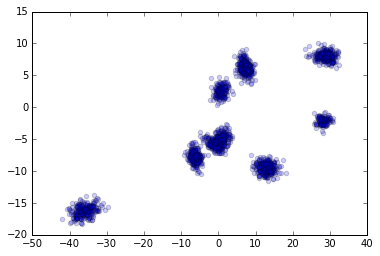

In [10]:
plt.scatter(X_train[:, 0], X_train[:, 1], alpha=.2)
#plt.axis([-3, 3, -3, 3])
plt.show()

In [11]:
N = X_train.shape[0]
N_test = X_test.shape[0]

In [12]:
alpha0 = 1

In [13]:
K = k  # number of components
D = d

mu = Normal(mu=tf.zeros([K, D]), sigma=tf.ones([K, D]))
sigma = InverseGamma(alpha=tf.ones([K, D]), beta=tf.ones([K, D]))
pi = Dirichlet(tf.ones(K)*alpha0)
z = Categorical(p=tf.stack([pi]*N))
components = [
    MultivariateNormalDiag(mu=tf.ones([N, 1]) * tf.gather(mu, k),
                           diag_stdev=tf.ones([N, 1]) * tf.gather(sigma, k))
    for k in range(K)]
x = Mixture(cat=z, components=components)

In [14]:
qpi_alpha = tf.nn.softplus(tf.Variable(tf.random_normal([K])))
qmu_mu = tf.Variable(tf.random_normal([K, D]))
qmu_sigma = tf.nn.softplus(tf.Variable(tf.random_normal([K, D])))
qsigma_alpha = tf.nn.softplus(tf.Variable(tf.random_normal([K, D])))
qsigma_beta = tf.nn.softplus(tf.Variable(tf.random_normal([K, D])))

qpi = Dirichlet(alpha=qpi_alpha)
qmu = Normal(mu=qmu_mu, sigma=qmu_sigma)
qsigma = InverseGamma(alpha=qsigma_alpha, beta=qsigma_beta)

In [15]:
sigma,qsigma

(<ed.RandomVariable 'InverseGamma/' shape=(10, 2) dtype=tf.float32>,
 <ed.RandomVariable 'InverseGamma_1/' shape=(10, 2) dtype=tf.float32>)

In [16]:
pi,qpi

(<ed.RandomVariable 'Dirichlet/' shape=(10,) dtype=tf.float32>,
 <ed.RandomVariable 'Dirichlet_1/' shape=(10,) dtype=tf.float32>)

In [17]:
x,X_train.shape

(<ed.RandomVariable 'Mixture/' shape=(2000, 2) dtype=tf.float32>, (2000, 2))

In [18]:
inference = ed.KLqp({pi: qpi, mu: qmu, sigma: qsigma}, data={x: X_train})
inference.run(n_iter=5000, n_samples=20) # spits out nan's
#inference.run(n_iter=5000, n_samples=1000)

Iteration    1 [  0%]: Loss = 31452.943
Iteration  500 [ 10%]: Loss = nan
Iteration 1000 [ 20%]: Loss = nan
Iteration 1500 [ 30%]: Loss = nan


KeyboardInterrupt: 

In [19]:
# Calculate likelihood for each data point and cluster assignment,
# averaged over many posterior samples. ``x_post`` has shape (N, 100, K, D).
mu_sample = qmu.sample(100)
sigma_sample = qsigma.sample(100)
x_post = Normal(mu=tf.ones([N, 1, 1, 1]) * mu_sample,
                sigma=tf.ones([N, 1, 1, 1]) * sigma_sample)
x_broadcasted = tf.tile(tf.reshape(X_train, [N, 1, 1, D]), [1, 100, K, 1])

ValueError: Dimensions must be equal, but are 2000 and 100 for 'mul_14' (op: 'Mul') with input shapes: [2000,1,1,1], [100,10,2,2].

In [ ]:
# Sum over latent dimension, then average over posterior samples.
# ``log_liks`` ends up with shape (N, K).
log_liks = x_post.log_prob(x_broadcasted)
log_liks = tf.reduce_sum(log_liks, 3)
log_liks = tf.reduce_mean(log_liks, 1)
clusters = tf.argmax(log_liks, 1).eval()
plt.scatter(X_train[:, 0], X_train[:, 1], c=clusters)#, cmap=cm.bwr)
plt.axis([-3, 3, -3, 3])
plt.title("Predicted cluster assignments")
plt.show()

In [ ]:
# Calculate likelihood for each data point and cluster assignment,
# averaged over many posterior samples. ``x_post`` has shape (N, 100, K, D).
mu_sample = qmu.sample(100)
sigma_sample = qsigma.sample(100)
x_post_pred = Normal(mu=tf.ones([N_test, 1, 1, 1]) * mu_sample,
                sigma=tf.ones([N_test, 1, 1, 1]) * sigma_sample)
x_broadcasted_pred = tf.tile(tf.reshape(X_test, [N_test, 1, 1, D]), [1, 100, K, 1])

In [ ]:
# Sum over latent dimension, then average over posterior samples.
# ``log_liks`` ends up with shape (N, K).
log_liks = x_post_pred.log_prob(x_broadcasted_pred)
log_liks = tf.reduce_sum(log_liks, 3)
log_liks = tf.reduce_mean(log_liks, 1)
clusters = tf.argmax(log_liks, 1).eval()
plt.scatter(X_test[:, 0], X_test[:, 1], c=clusters)#, cmap=cm.bwr)
plt.axis([-3, 3, -3, 3])
plt.title("Predicted cluster assignments")
plt.show()

In [ ]:
log_liks.shape

In [ ]:
tf.reduce_max(log_liks, 1).eval().sum()

In [ ]:
np.max(log_liks.eval(),1).sum()